In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
from glob import glob
import cv2
import numpy as np
import pandas as pd
import random

Mounted at /content/drive


In [ ]:
# 감정 label 리스트
path_all = '/content/drive/MyDrive/AI 감정인식 프로젝트/datasets/'
file_paths = glob(f'{path_all}*')
label_emo = []

for i in range(len(file_paths)):
  label_emo.append(file_paths[i].split('/')[-1])

label_emo

['angry', 'sad', 'neutral', 'surprise', 'fear', 'happy', 'disgust']

In [ ]:
import glob
list_all = []

# emotion을 0-6까지의 숫자로 저장
for j, emo in enumerate(label_emo):
  image_files = glob.glob(path_all+emo+'/*')

  for i, image in enumerate(image_files):
    image = cv2.imread(image)

    try:
      image = np.mean(image, axis = 2)
      image = image.astype('float32')
      image = image / 255
      image = np.reshape(image,(48,48))
        
      list_all.append([image,j])
    
    except:
      pass

len(list_all)

 # emotion_df.to_csv('/content/drive/MyDrive/data_full.csv', sep=',', na_rep='NaN')

25028

In [ ]:
image_all = []  
for i in list_all:
    image_all.append(i[0])


emotion_all = [] 
for i in list_all:
    emotion_all.append(i[1])

In [ ]:
from sklearn.model_selection import train_test_split

#image = emotion_df['image']
#emotion = emotion_df['emotion']

x_train, x_valid, y_train, y_valid = train_test_split(image_all, emotion_all, test_size = 0.2)
# 각 emotion마다 데이터 갯수가 비슷하도록 split 하는 방법 배웠는데 기억이 안남 -> 너무 이미지 수가 많이 차이남 => 그냥 자체적으로 자르고 진행해야 할 듯 하다.
# stratify가 적용되도 뭐....비슷하다..?

# 적당한 비율(2:8)로 split된 것을 확인
print(len(x_train))
print(len(x_valid))

20022
5006


In [ ]:
x_train = np.array(x_train)
x_valid = np.array(x_valid)
y_train = np.array(y_train)
y_valid = np.array(y_valid)

x_train = x_train.reshape((x_train.shape[0], 48, 48, 1))
x_valid = x_valid.reshape((x_valid.shape[0], 48, 48, 1))

print(x_train.shape)
print(x_valid.shape)

(20022, 48, 48, 1)
(5006, 48, 48, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 64)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 33856)             0         
                                                                 
 dense1 (Dense)              (None, 128)               4333696   
                                                                 
 dense2 (Dense)              (None, 64)                8256      
                                                                 
 dense3 (Dense)              (None, 32)                2080      
                                                        

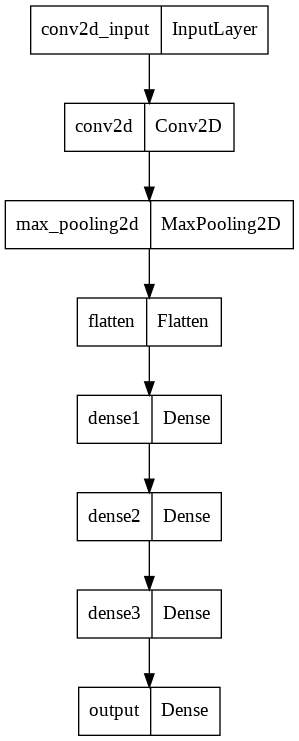

In [ ]:
# module import
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping


# model 구성하고 summary, 시각화
model = Sequential([Conv2D(64,(3, 3), activation='relu', input_shape = (48, 48,1)),
                    MaxPooling2D((2, 2)),
                    Flatten(),
                    Dense(128, activation='relu', name='dense1'),
                    Dense(64, activation='relu', name='dense2'),
                    Dense(32, activation='relu', name='dense3'),
                    Dense(7, activation='softmax', name='output')])

model.summary() # 모델의 요약 정보 출력
plot_model(model) # 모델 구조를 시각적으로 표현

In [ ]:
# model compile

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor = 'accuracy', patience = 5)

* 기존의 수연님 코드에는 validation_set를 통해 검증용 데이터에 대한 정확도를 고려하지 않았음을 확인할 수 있었다.
* 학습 데이터로 학습을 하고, 해당 데이터만으로 학습 결과를 test하는 것은 특정 사진에만 정답률이 높아지는, 이른바 overfitting의 위험성이 있다.
* validation_set를 만들고, 이에 대한 test도 시행함.

In [ ]:
# fit
history = model.fit(x_train ,y_train, 
                    epochs = 50, 
                    batch_size=64,
                    verbose = 1,
                    validation_data = (x_valid,y_valid), # 모델에 fit시킬 때 validation_set도 같이 넣어주어야 함
                    callbacks=[early_stopping])

Epoch 1/50
313/313 [==============================] - 45s 145ms/step - loss: 1.4719 - accuracy: 0.4596 - val_loss: 1.5469 - val_accuracy: 0.4273
Epoch 2/50
313/313 [==============================] - 62s 199ms/step - loss: 1.4464 - accuracy: 0.4725 - val_loss: 1.5313 - val_accuracy: 0.4333
Epoch 3/50
313/313 [==============================] - 46s 148ms/step - loss: 1.4247 - accuracy: 0.4775 - val_loss: 1.4929 - val_accuracy: 0.4505
Epoch 4/50
313/313 [==============================] - 45s 144ms/step - loss: 1.3973 - accuracy: 0.4900 - val_loss: 1.4698 - val_accuracy: 0.4598
Epoch 5/50
313/313 [==============================] - 45s 145ms/step - loss: 1.3730 - accuracy: 0.4977 - val_loss: 1.4615 - val_accuracy: 0.4650
Epoch 6/50
313/313 [==============================] - 45s 144ms/step - loss: 1.3489 - accuracy: 0.5069 - val_loss: 1.4230 - val_accuracy: 0.4788
Epoch 7/50
313/313 [==============================] - 46s 146ms/step - loss: 1.3206 - accuracy: 0.5185 - val_loss: 1.4080 - val_ac

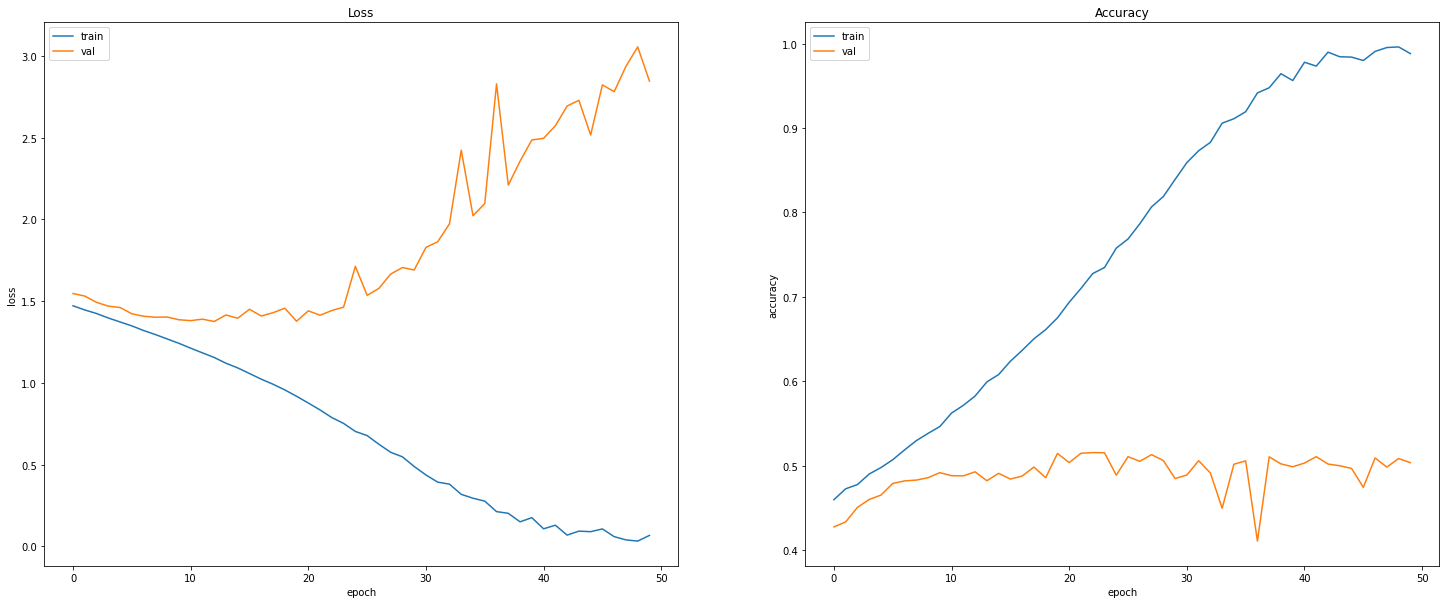

In [ ]:
# loss 값과 accuracy 시각화
# train & valid

import matplotlib.pyplot as plt

history = history.history

plt.figure(figsize=(25, 10))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()

In [ ]:
score = model.evaluate(x_valid,y_valid,verbose = 1)
print('정답률 = ',score[1],'loss = ',score[0])

157/157 [==============================] - 3s 18ms/step - loss: 2.8462 - accuracy: 0.5034
정답률 =  0.5033959150314331 loss =  2.8461825847625732


In [ ]:
model.save('/content/drive/MyDrive/AI프로젝트 모델링용/emotion_model.h5')
# new_model = tf.keras.models.load_model('emotion_model.h5') 로 불러오기